<ipython-input-13-1954d3fbcd67>:133: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',xytext=centerPt, textcoords='axes fraction',


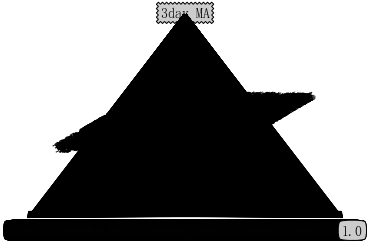

UnboundLocalError: local variable 'classLabel' referenced before assignment

In [13]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from math import log
import operator
import pickle
import numpy as np
import re
 
# import csv
def loadDataSet(filename):
    dataset = []
    features = []
    bool=0
    with open(filename, 'r') as fr:
        for line in fr.readlines():
            if not line:
                continue
            lineArr = []
            for feature in line.split(','):
                str_f = feature.strip()
                if str_f[0].isalpha() or 'day' in str_f:
                    features.append(str_f)
                    bool=1    
                else:
                    if not re.match("\d{4}-\d{1,2}-\d{1,2}",str_f):
                        lineArr.append(float(str_f))
                    bool=0
            if bool==0:
                dataset.append(lineArr)
    return dataset, features


def calcShannonEnt(dataSet):
	numEntires = len(dataSet)						
	labelCounts = {}							
	for featVec in dataSet:							
		currentLabel = featVec[-1]					
		if currentLabel not in labelCounts.keys():	
			labelCounts[currentLabel] = 0
		labelCounts[currentLabel] += 1				
	shannonEnt = 0.0							
	for key in labelCounts:							
		prob = float(labelCounts[key]) / numEntires	
		shannonEnt -= prob * log(prob, 2)			
	return shannonEnt			
							

def splitDataSet(dataSet, axis, value):		
	retDataSet = []									
	for featVec in dataSet: 							
		if featVec[axis] == value:
			reducedFeatVec = featVec[:axis]			
			reducedFeatVec.extend(featVec[axis+1:]) 	
			retDataSet.append(reducedFeatVec)
	return retDataSet		  						


def chooseBestFeatureToSplit(dataSet):
	numFeatures = len(dataSet[0]) - 1				
	baseEntropy = calcShannonEnt(dataSet) 			
	bestInfoGain = 0.0  								
	bestFeature = -1									
	for i in range(numFeatures): 						
		featList = [example[i] for example in dataSet]
		uniqueVals = set(featList)     					
		newEntropy = 0.0  								
		for value in uniqueVals: 						
			subDataSet = splitDataSet(dataSet, i, value) 		
			prob = len(subDataSet) / float(len(dataSet))   		
			newEntropy += prob * calcShannonEnt(subDataSet) 	
		infoGain = baseEntropy - newEntropy 					
		if (infoGain > bestInfoGain): 							
			bestInfoGain = infoGain 						
			bestFeature = i 									
	return bestFeature 											


def majorityCnt(classList):
	classCount = {}
	for vote in classList:										
		if vote not in classCount.keys():classCount[vote] = 0	
		classCount[vote] += 1
	sortedClassCount = sorted(classCount.items(), key = operator.itemgetter(1), reverse = True)		
	return sortedClassCount[0][0]								


def createTree(dataSet, labels, featLabels):
	classList = [example[-1] for example in dataSet]			
	if classList.count(classList[0]) == len(classList):			
		return classList[0]
	if len(dataSet[0]) == 1 or len(labels) == 0:									
		return majorityCnt(classList)
	bestFeat = chooseBestFeatureToSplit(dataSet)			
	bestFeatLabel = labels[bestFeat]						
	featLabels.append(bestFeatLabel)
	myTree = {bestFeatLabel:{}}									
	del(labels[bestFeat])										
	featValues = [example[bestFeat] for example in dataSet]		
	uniqueVals = set(featValues)								
	for value in uniqueVals:									
		subLabels = labels[:]
		myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels, featLabels)
        
	return myTree


def getNumLeafs(myTree):
    numLeafs = 0												
    firstStr = next(iter(myTree))								
    secondDict = myTree[firstStr]								
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':				
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs


def getTreeDepth(myTree):
    maxDepth = 0												
    firstStr = next(iter(myTree))								
    secondDict = myTree[firstStr]							
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':				
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth			
    return maxDepth


def plotNode(nodeTxt, centerPt, parentPt, nodeType):
	arrow_args = dict(arrowstyle="<-")											
	font = FontProperties(fname=r"c:\windows\fonts\simsunb.ttf", size=14)		
	createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',xytext=centerPt, textcoords='axes fraction',
		va="center", ha="center", bbox=nodeType, arrowprops=arrow_args, FontProperties=font)


def plotMidText(cntrPt, parentPt, txtString):
	xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]														
	yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
	createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)


def plotTree(myTree, parentPt, nodeTxt):
	decisionNode = dict(boxstyle="sawtooth", fc="0.8")								
	leafNode = dict(boxstyle="round4", fc="0.8")											
	numLeafs = getNumLeafs(myTree)  												
	depth = getTreeDepth(myTree)												
	firstStr = next(iter(myTree))														   								
	cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)	
	plotMidText(cntrPt, parentPt, nodeTxt)												
	plotNode(firstStr, cntrPt, parentPt, decisionNode)									
	secondDict = myTree[firstStr]														
	plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD									
	for key in secondDict.keys():								
		if type(secondDict[key]).__name__=='dict':										
			plotTree(secondDict[key],cntrPt,str(key))        								
		else:																											
			plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
			plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
			plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
	plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD


def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')												
    fig.clf()																				
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    							
    plotTree.totalW = float(getNumLeafs(inTree))											
    plotTree.totalD = float(getTreeDepth(inTree))											
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;								
    plotTree(inTree, (0.5,1.0), '')															
    plt.show()																				


def classify(inputTree, featLabels, testVec):
	firstStr = next(iter(inputTree))													
	secondDict = inputTree[firstStr]														
	featIndex = featLabels.index(firstStr)												
	for key in secondDict.keys():
		if testVec[featIndex] == key:
			if type(secondDict[key]).__name__ == 'dict':
				classLabel = classify(secondDict[key], featLabels, testVec)
			else: classLabel = secondDict[key]
	return classLabel

def grabTree(filename):
	fr = open(filename, 'rb')
	return pickle.load(fr)


if __name__ == '__main__':
    dataset, labels = loadDataSet('./pred.csv')
    featLabels = []
    myTree = createTree(dataset, labels, featLabels)
    createPlot(myTree)
    testVec = [0,1]									
    result = classify(myTree, featLabels, testVec)
    if result == 'yes':
        print('1')
    if result == 'no':
        print('-1')